#  Notebook Objective

This notebook serves as a **sandbox for experimentation and exploration** of various **time series forecasting techniques**, using the rich and complex dataset from the **Kaggle M5 Forecasting - Accuracy** competition.

The goal is to apply, analyze, and compare different forecasting models—from classical statistical approaches like **ARIMA**, to more advanced machine learning-based methods—in order to better understand sales dynamics and accurately predict future demand.

This notebook is designed to support flexible experimentation at multiple aggregation levels (e.g., by store, by department, or overall), enabling tests of different model configurations, forecasting horizons, and evaluation metrics.

Ultimately, this notebook is envisioned as a **dynamic canvas**, where each code block contributes to building a deeper, more practical understanding of how to tackle real-world forecasting challenges using the M5 dataset as a reference point.




In [60]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima
from pmdarima.arima import ADFTest


from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import os
import lightgbm as lgb

from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 



In [61]:
# load sales data
salesdf = pd.read_csv('sales_train_validation.csv')
salesdf = salesdf.loc[salesdf.state_id == 'CA']
salesdf['id'] = salesdf['item_id'] + '_' + salesdf['store_id'] + '_' + 'validation'
salesdf.head(5)

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,id
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,3,0,1,1,1,3,0,1,1,HOBBIES_1_001_CA_1_validation
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,HOBBIES_1_002_CA_1_validation
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,2,1,1,1,0,1,1,1,HOBBIES_1_003_CA_1_validation
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,5,4,1,0,1,3,7,2,HOBBIES_1_004_CA_1_validation
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,1,1,2,2,2,4,HOBBIES_1_005_CA_1_validation


In [62]:
# function to reduce memory usage of a DataFrame, seen on Kaggle

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


salesdf = reduce_mem_usage(salesdf)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 35.74 MB
Decreased by 80.0%


In [63]:
# melt the data into long format
salesdf = pd.melt(salesdf, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()



In [64]:
# get timne series calendar data
caldf = pd.read_csv('calendar.csv')
caldf['d']  = 'd' + '_' + (caldf.index + 1).astype(str)
caldf['date'] = pd.to_datetime(caldf['date'])

In [65]:
# mergfe sales data with calendar data
salesdf = pd.merge(salesdf, caldf, on='d', how='left')
del caldf

* All stores Demand Forecasting per cat

In [66]:
salesdf.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


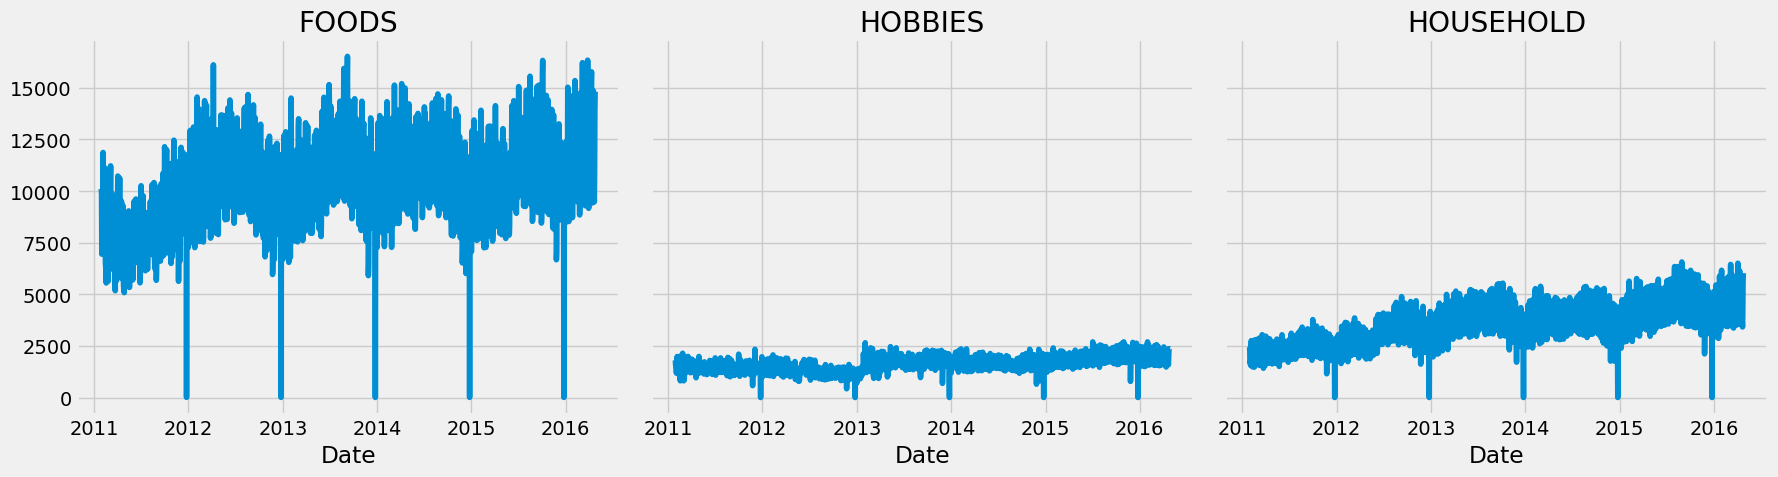

In [67]:
# unique departments

depts = sorted(salesdf['cat_id'].unique())

# create plots for each department
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=True, sharey=True)


for i, dept in enumerate(depts):
    salesdf_dept = salesdf[salesdf['cat_id'] == dept]
    sales_by_date = salesdf_dept.groupby('date')['sales'].sum()
    axes[i].plot(sales_by_date.index, sales_by_date.values)
    axes[i].set_title(f'{dept}')
    axes[i].set_xlabel('Date')



plt.tight_layout()
plt.show()

#  Arima Decomposing Foods
*WIP*

In [68]:
# group by date and sum sales for the 'FOODS' category  
ts = salesdf[salesdf['cat_id']=='FOODS'].groupby('date')['sales'].sum()

# ensure the time series is complete by reindexing with a date range
ts = ts.asfreq('D')  

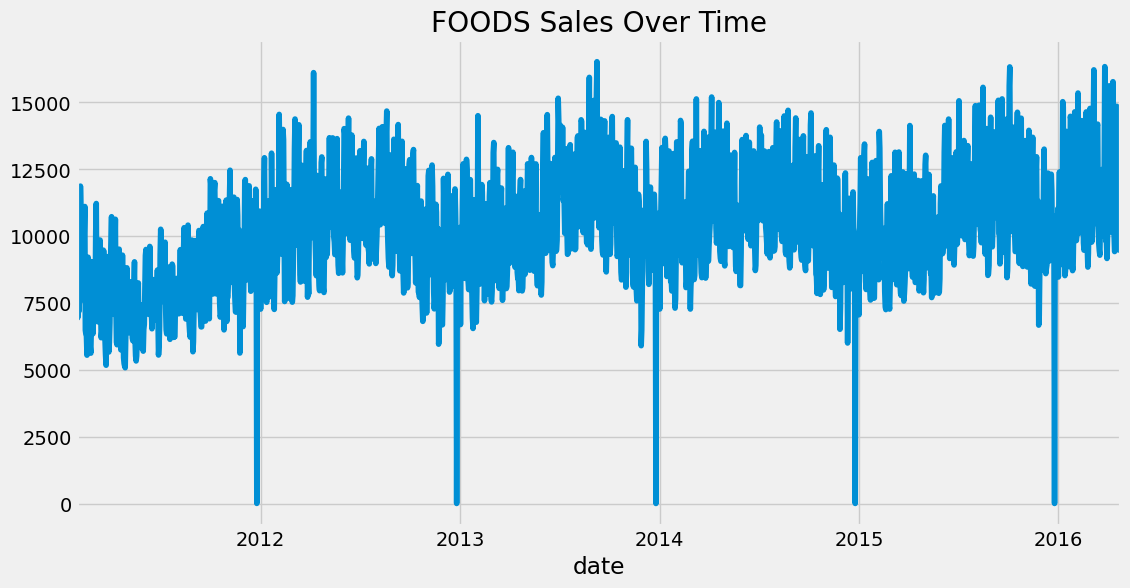

In [69]:

ts.plot(title='FOODS Sales Over Time', figsize=(12, 6))
plt.show()

In [70]:
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)
adf_test = ADFTest(alpha=0.05)
adf_result = adf_test.should_diff(ts)
print(f"ADF Test Result: {adf_result}")

ADF Test Result: (0.01, False)


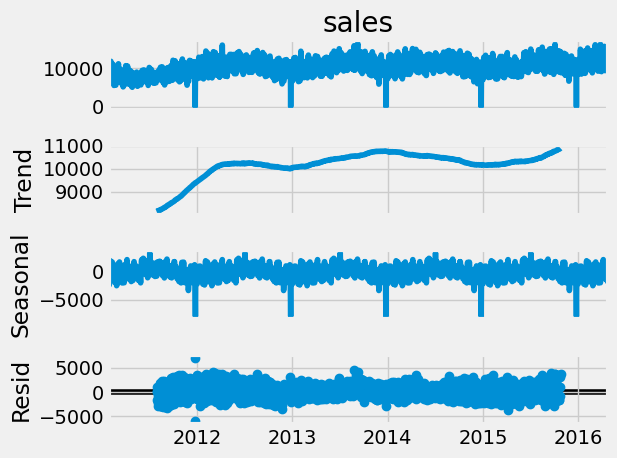

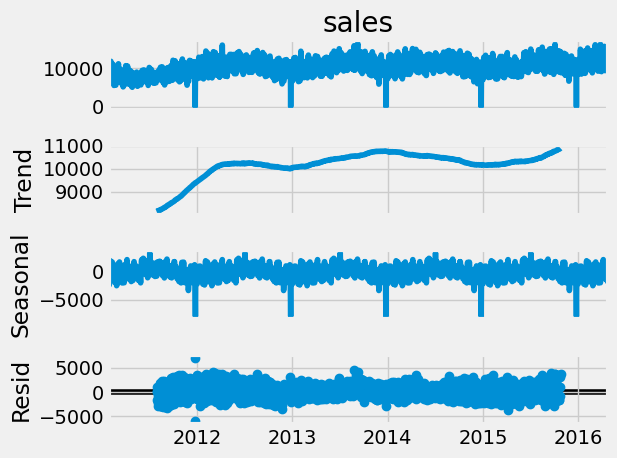

In [71]:


result = seasonal_decompose(ts, model='additive', period = 365)

result.plot()

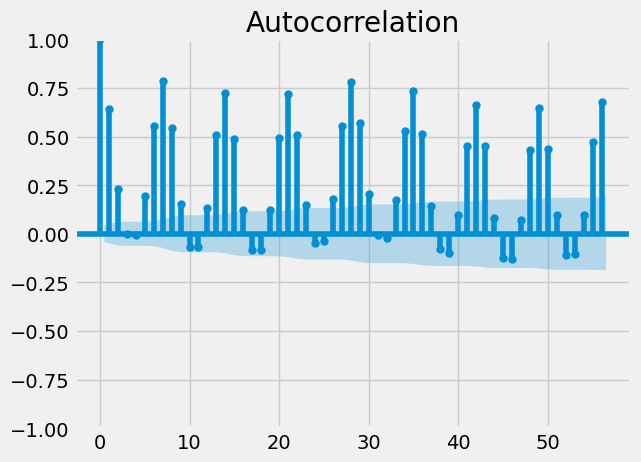

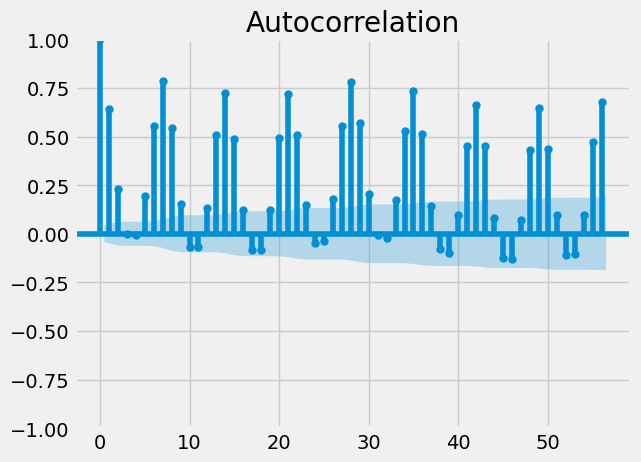

In [72]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts, lags=56)

In [73]:


# Usung auto_arima to find the best ARIMA model for the time series
model_auto = auto_arima(ts, seasonal=True, trace=True, suppress_warnings=True)
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32932.754, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34081.555, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34070.617, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34059.710, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34079.559, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=33381.505, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33186.297, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=32843.360, Time=0.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33093.235, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=32386.041, Time=0.76 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=32929.158, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=32283.302, Time=0.70 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=32614.549, Time=0.20 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=32280.748, Time=0.79 sec
 ARIMA(4,1,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1913
Model:               SARIMAX(4, 1, 5)   Log Likelihood              -16030.662
Date:                Sat, 31 May 2025   AIC                          32081.324
Time:                        16:01:52   BIC                          32136.883
Sample:                    01-29-2011   HQIC                         32101.771
                         - 04-24-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8037      0.007    117.913      0.000       0.790       0.817
ar.L2         -1.4313      0.009   -163.610      0.000      -1.448      -1.414
ar.L3          0.7845      0.009     89.390      0.000       0.767       0.802
ar.L4         -0.9837      0.007   -143.891      0.000      -0.997      -0.970
ma.L1         -1.4158      0.019    -75.258      0.000      -1.453      -1.379
ma.L2          1.8286      0.029     62.941      0.000       1.772       1.886
ma.L3         -1.5289      0.045    -34.346      0.000      -1.616      -1.442
ma.L4          1.3266      0.038     34.693      0.000       1.252       1.401
ma.L5         -0.5702      0.026    -21.954      0.000      -0.621      -0.519
sigma2      1.509e+06   2.72e-08   5.55e+13      0.000    1.51e+06    1.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.69   Jarque-Bera (JB):             32853.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -1.92
Prob(H) (two-sided):                  0.02   Kurtosis:                        22.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.9e+28. Standard errors may be unstable.
"""

In [74]:
model = ARIMA(ts, order=(4, 1, 5)) 
model_fit = model.fit()


print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1913
Model:                 ARIMA(4, 1, 5)   Log Likelihood              -16030.662
Date:                Sat, 31 May 2025   AIC                          32081.324
Time:                        16:01:53   BIC                          32136.883
Sample:                    01-29-2011   HQIC                         32101.771
                         - 04-24-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8037      0.007    117.913      0.000       0.790       0.817
ar.L2         -1.4313      0.009   -163.610      0.000      -1.448      -1.414
ar.L3          0.7845      0.009     89.390      0.0

c:\Users\jdv_k\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


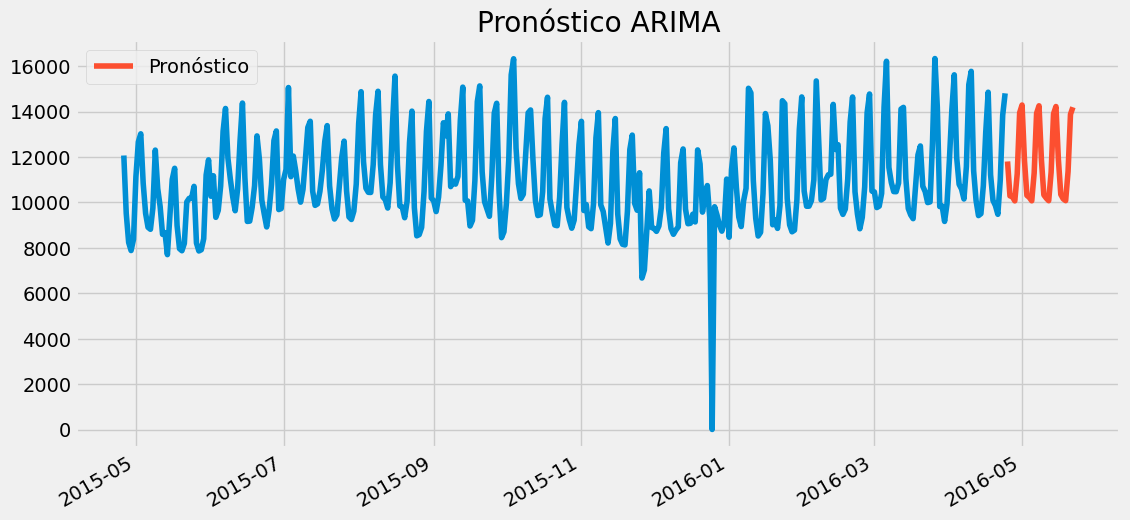

In [75]:

forecast = model_fit.forecast(steps=28)
plt.figure(figsize=
           (12, 6))
# Visualizar
plt.plot(ts[-365:].index, ts[-365:].values, label='Datos Históricos')
forecast.plot(label='Pronóstico', legend=True)
plt.title('Pronóstico ARIMA')
plt.show()

* WIP

In [76]:
# Check for unique categories in the categorical columns

cats = ['cat_id', 'store_id']

for col in cats:
    print(f'Column: {col}',salesdf[col].unique())

Column: cat_id ['HOBBIES', 'HOUSEHOLD', 'FOODS']
Categories (3, object): ['FOODS', 'HOBBIES', 'HOUSEHOLD']
Column: store_id ['CA_1', 'CA_2', 'CA_3', 'CA_4']
Categories (4, object): ['CA_1', 'CA_2', 'CA_3', 'CA_4']


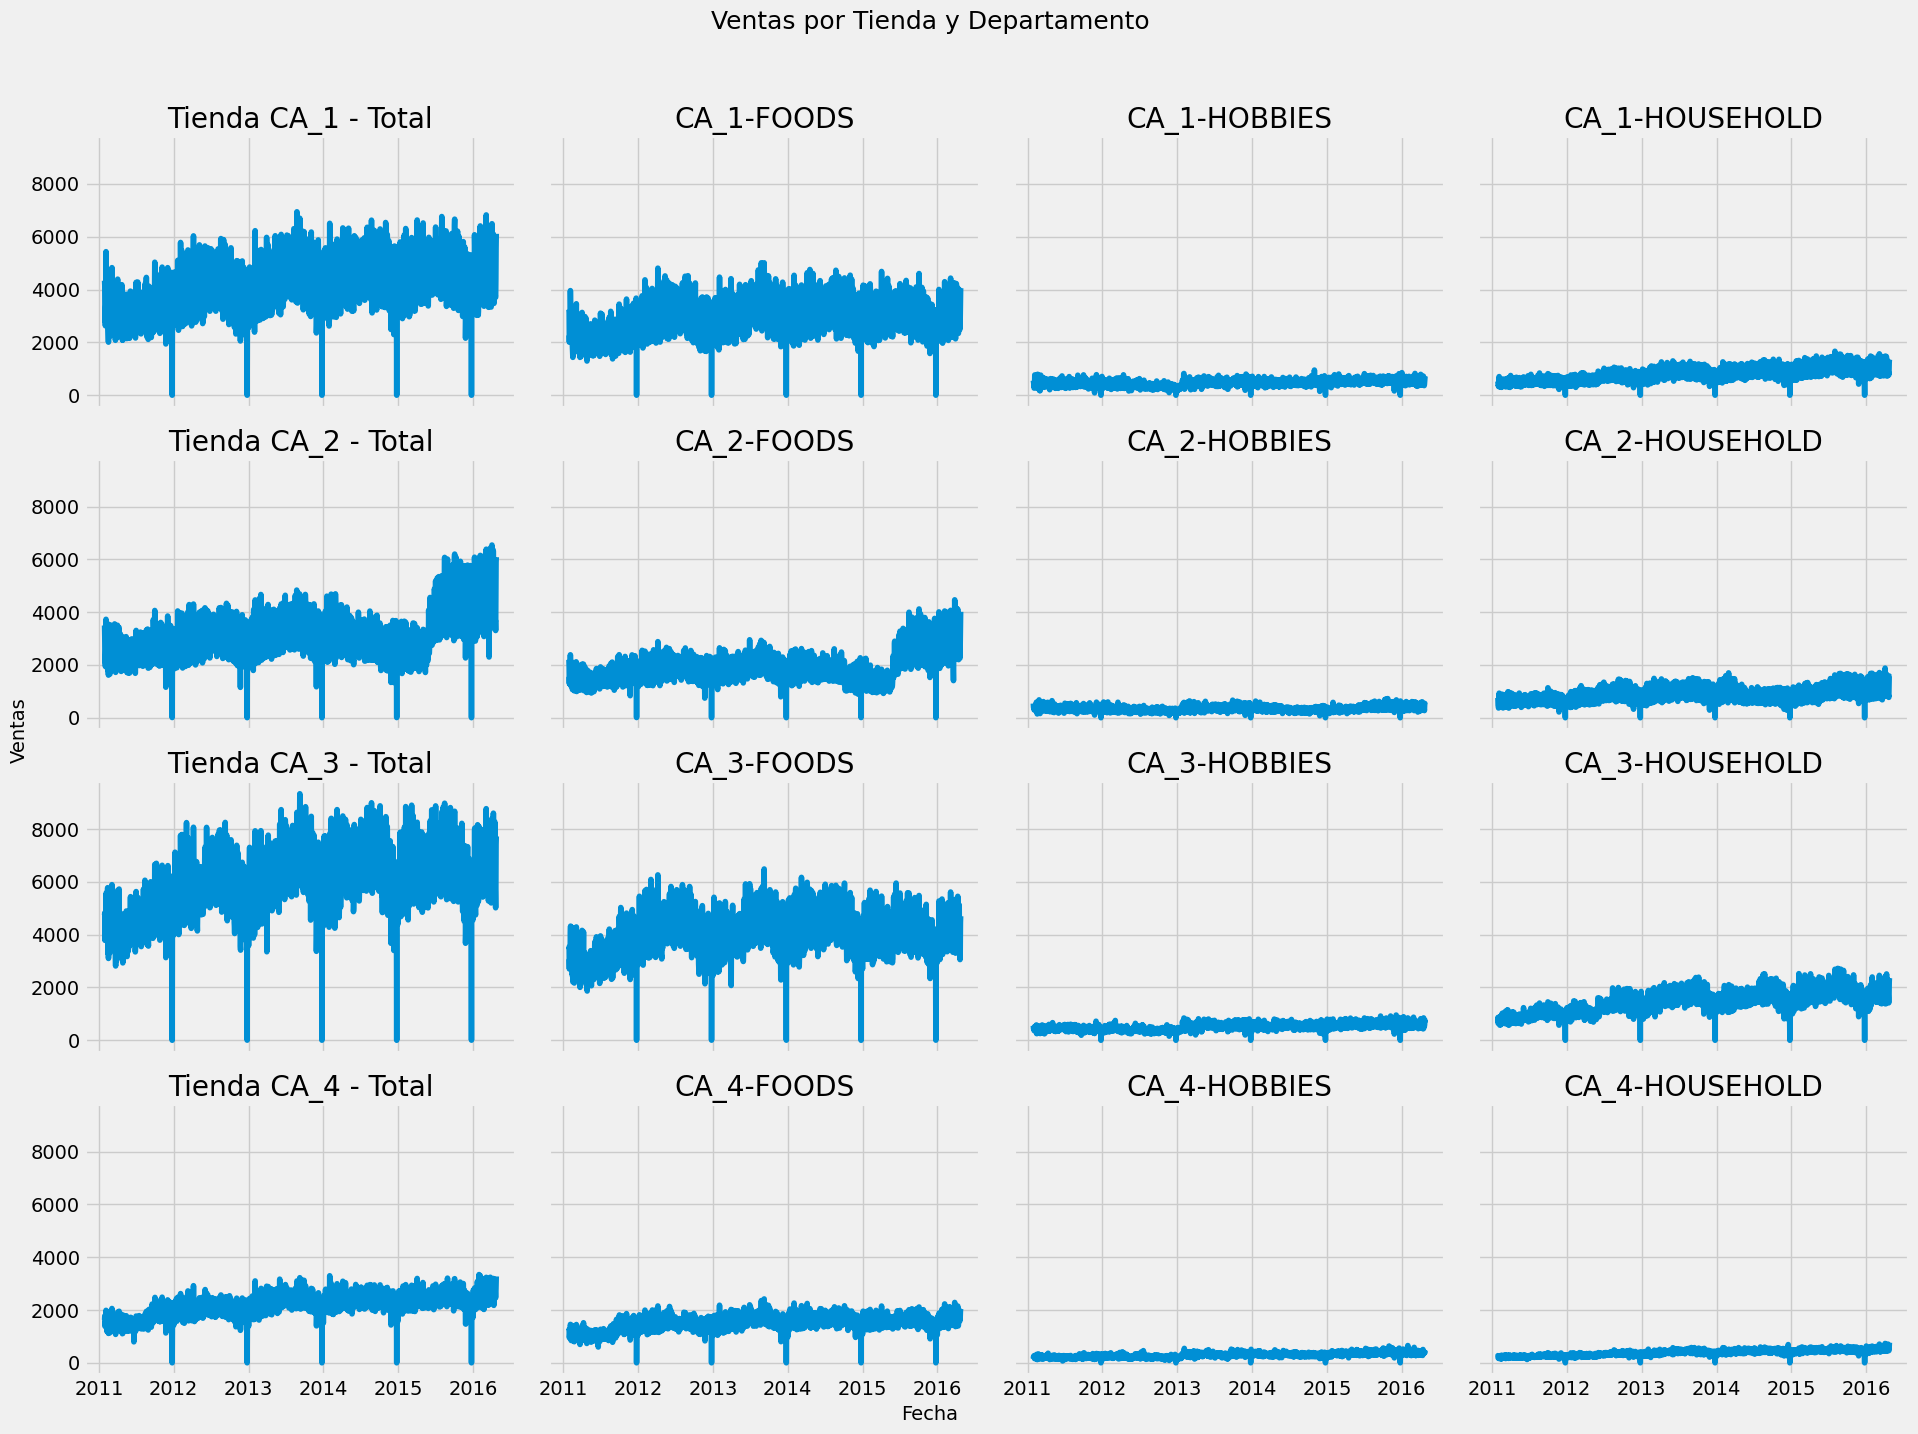

In [77]:
# plotting  sales per store per cat


stores = sorted(salesdf['store_id'].unique())
depts = sorted(salesdf['cat_id'].unique())

# Crear el subplot 4x4
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15), sharex=True, sharey=True)

for i, store in enumerate(stores):
    # Fila i, Columna 0 → todos los departamentos (ventas totales por tienda)
    salesdf_store = salesdf[salesdf['store_id'] == store]
    total_sales = salesdf_store.groupby('date')['sales'].sum()
    axes[i, 0].plot(total_sales.index, total_sales.values)
    axes[i, 0].set_title(f'Tienda {store} - Total')
    
    # Columnas 1 a 3 → ventas por departamento
    for j, dept in enumerate(depts):
        salesdf_sd = salesdf_store[salesdf_store['cat_id'] == dept]
        sales = salesdf_sd.groupby('date')['sales'].sum()
        axes[i, j+1].plot(sales.index, sales.values)
        axes[i, j+1].set_title(f'{store}-{dept}')

# Etiquetas generales
fig.suptitle('Ventas por Tienda y Departamento', fontsize=18)
fig.text(0.5, 0.04, 'Fecha', ha='center')
fig.text(0.04, 0.5, 'Ventas', va='center', rotation='vertical')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()